# Load the Data and understand it 

### Importing libraries 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

### Loading the dataset

In [2]:
df = pd.read_csv('online_retail.csv')

In [3]:
# Dataset first five features 
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2022-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2022-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2022-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2022-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2022-12-01 08:26:00,3.39,17850.0,United Kingdom


In [4]:
# Dataset Structure
df.shape

(541909, 8)

In [5]:
# Dataset info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [6]:
# Null values 
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [7]:
# Duplicate values 
df.duplicated().sum()

5268

In [8]:
# Dropping duplicate values 
df.drop_duplicates(inplace=True)

# Data Preprocessing

In [9]:
# Remove rows with missings values in 'CustomerID'
df = df.dropna(subset=['CustomerID'])

In [10]:
df.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [11]:
# Remove cancelled invoices (Starting with 'C')
df = df[~ df['InvoiceNo'].astype(str).str.startswith('C')]

In [12]:
# Removing rows with negative or zero quantities and prices 
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]

In [13]:
import warnings
warnings.filterwarnings('ignore')

# converting 'InvoiceDate' to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [14]:
# Adding 'Total_price' variable quantity * price
df['Total_price'] = df['Quantity'] * df['UnitPrice']

# EDA 

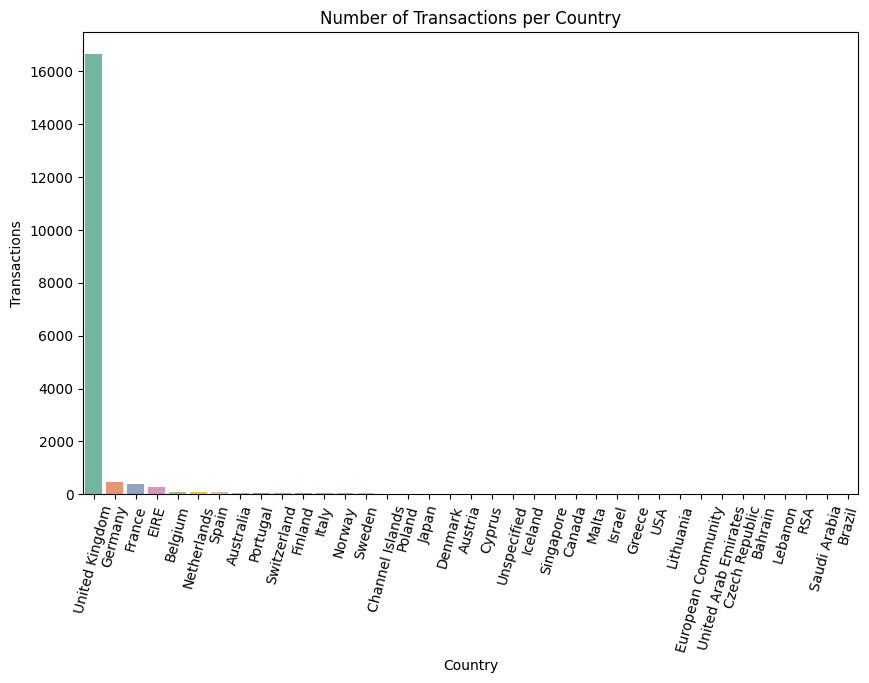

In [15]:
tran_per_country = df.groupby('Country')['InvoiceNo'].nunique().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=tran_per_country.index, y=tran_per_country.values, palette="Set2")
plt.title('Number of Transactions per Country')
plt.xlabel('Country')
plt.ylabel('Transactions')
plt.xticks(rotation=75)
plt.show()

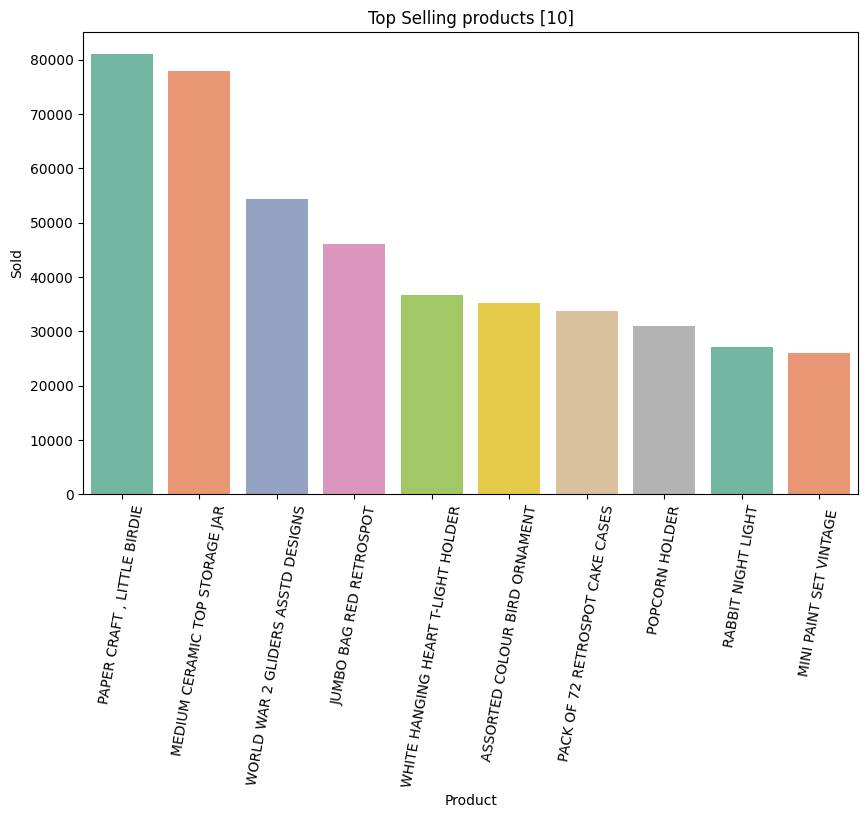

In [16]:
# Identify top-selling products
top_products = df.groupby('Description')['Quantity'].sum().sort_values(ascending=False).head(10)
plt.figure(figsize=[10,6])
sns.barplot(x=top_products.index,y=top_products.values,palette='Set2')
plt.title('Top Selling products [10]')
plt.xlabel('Product')
plt.ylabel('Sold')
plt.xticks(rotation=80)
plt.show()

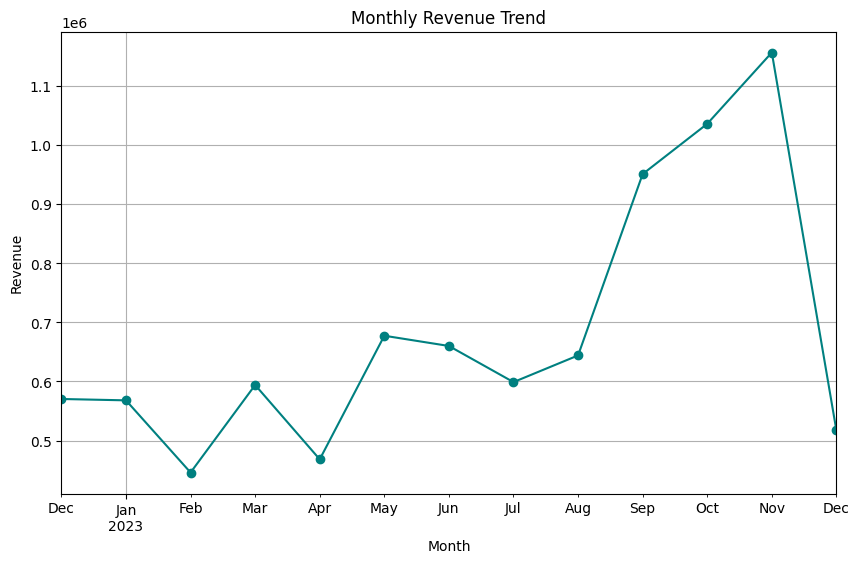

In [17]:
# Visualize purchase trends over time
df['Invoic_month'] = df['InvoiceDate'].dt.to_period('M')
monthly_revenue = df.groupby('Invoic_month')['Total_price'].sum()

plt.figure(figsize=(10, 6))
monthly_revenue.plot(marker='o', color='teal')
plt.title('Monthly Revenue Trend')
plt.xlabel('Month')
plt.ylabel('Revenue')
plt.grid(True)
plt.show()

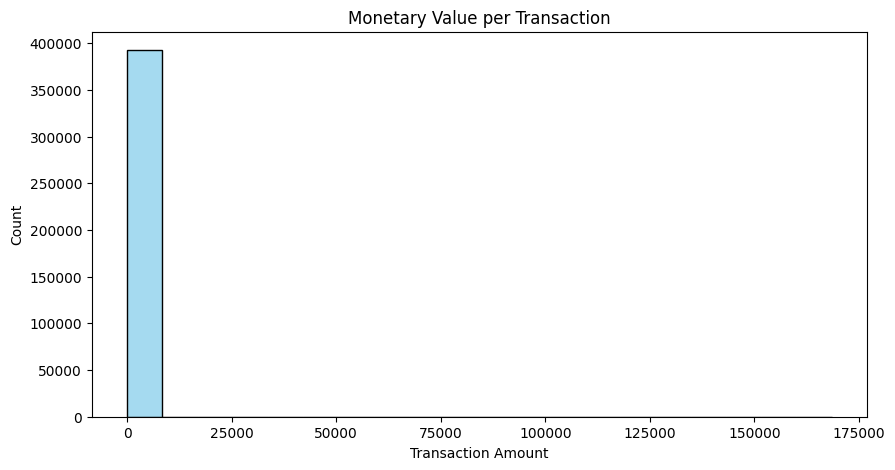

In [18]:
# Inspect monetary distribution per transaction and customer
# Transaction Distribution 
plt.figure(figsize=(10, 5))
sns.histplot(df['Total_price'] ,bins=20,  color='skyblue')
plt.title('Monetary Value per Transaction')
plt.xlabel('Transaction Amount')
plt.show()

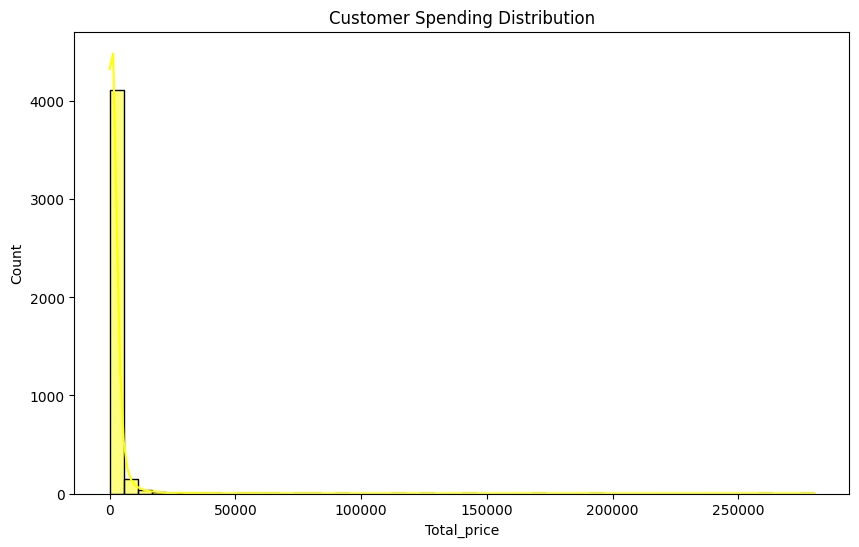

In [19]:
# Customer Spending Distribution 
customer_spend = df.groupby('CustomerID')['Total_price'].sum()
plt.figure(figsize=[10,6])
sns.histplot(data=customer_spend,bins=50,kde=True,color='yellow')
plt.title('Customer Spending Distribution')
plt.show()

In [20]:
# RFM distributions
latest_date = df['InvoiceDate'].max() + timedelta(days=1)

rfm = df.groupby('CustomerID').agg({
    'InvoiceDate' : lambda x: (latest_date - x.max()).days,
    'InvoiceNo' : 'nunique',
    'Total_price' : 'sum'
}).reset_index()

rfm.columns = ['CustomerID','Recency','Frequency','Monetary']

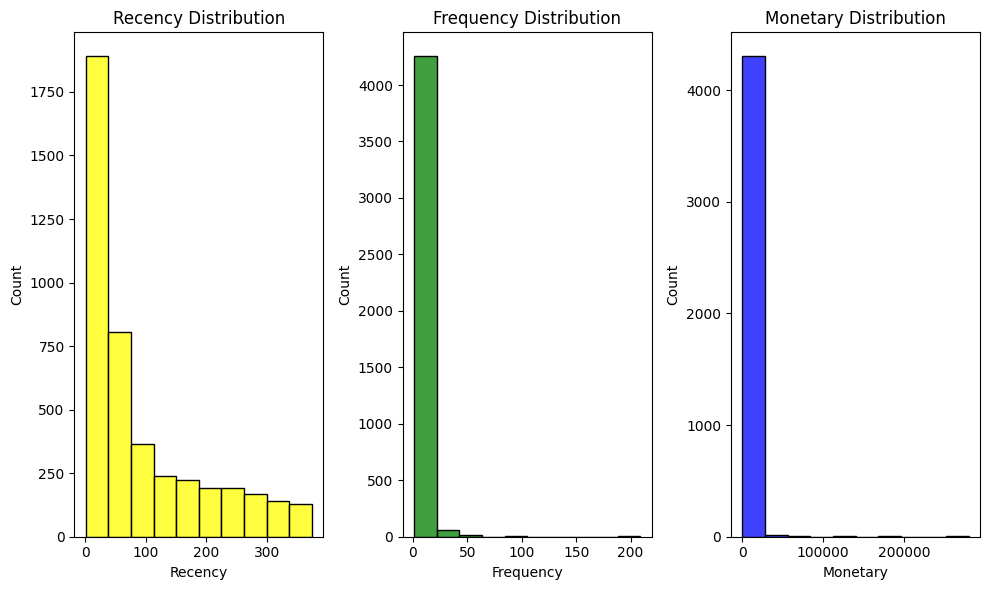

In [21]:
# plotting RFM Distribution

plt.figure(figsize=[10,6])
# Recency
plt.subplot(1,3,1)
sns.histplot(rfm['Recency'],bins=10,color='yellow')
plt.title('Recency Distribution')

# Frequency
plt.subplot(1,3,2)
sns.histplot(rfm['Frequency'],bins=10,color='green')
plt.title('Frequency Distribution')

# Monetary
plt.subplot(1,3,3)
sns.histplot(rfm['Monetary'],bins=10,color='blue')
plt.title('Monetary Distribution')

plt.tight_layout()
plt.show()

In [22]:
# Elbow curve for cluster selection
from sklearn.cluster import KMeans
X = rfm[['Recency','Frequency','Monetary']]
sum_square = []  # sum of squared errors

# trying value of k from 1 to 10 
for k in range(1,11):
    kmeans = KMeans(n_clusters=k,random_state=123)
    kmeans.fit(X)
    sum_square.append(kmeans.inertia_)

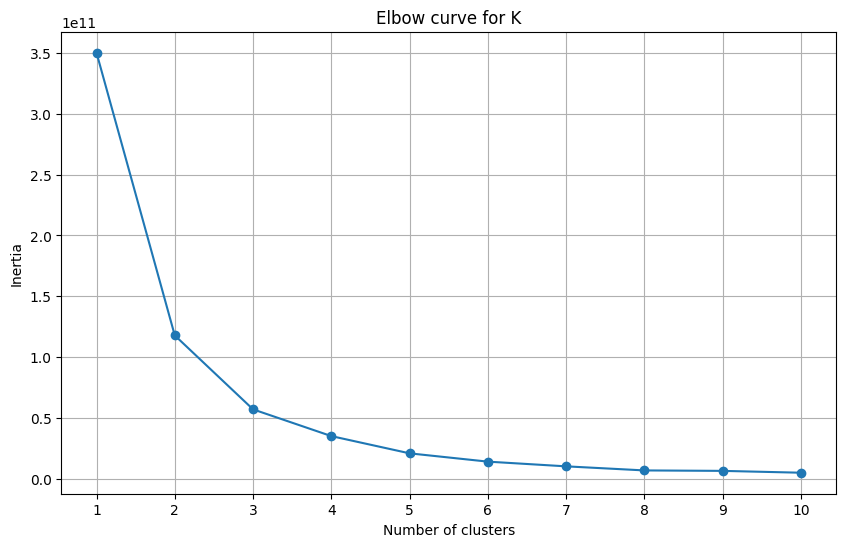

In [23]:
# Plotting the elbow curve 
plt.figure(figsize=[10,6])
plt.plot(range(1,11),sum_square,marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow curve for K')
plt.xticks(range(1,11))
plt.grid(True)
plt.show()

In [24]:
# We clearly see that the curve drops between k=1 to k=3
# so picking k=3

In [25]:
# scaling the rfm data 
from sklearn.preprocessing import StandardScaler
SS = StandardScaler()
X_scaled = SS.fit_transform(X)

In [26]:
# Assigning clusters 
kmeans = KMeans(n_clusters=3,random_state=123)
rfm['Clusters'] = kmeans.fit_predict(X_scaled)

In [27]:
# Customer cluster profiles
cust_profile = rfm.groupby('Clusters')[['Recency','Frequency','Monetary']].mean().round(1)
print(cust_profile)

          Recency  Frequency  Monetary
Clusters                              
0           246.0        1.6     629.4
1             7.1       80.2  122748.8
2            41.0        4.9    2005.8


In [28]:
# Interpretting the cluster 

|Cluster|Recency|Frequency|Monetary|Label|
|-|-|-|-|-|
|0|High|Low|Low|At Rsik|
|||||
|1|Low|High|High|High-Value|
|||||
|2|Medium|Medium|Medium|Regular|

In [29]:
# Labelling 
segment_map = {
    0:'At Risk',
    1:'High-Value',
    2:'Regular'
}

rfm['Segment'] = rfm['Clusters'].map(segment_map)

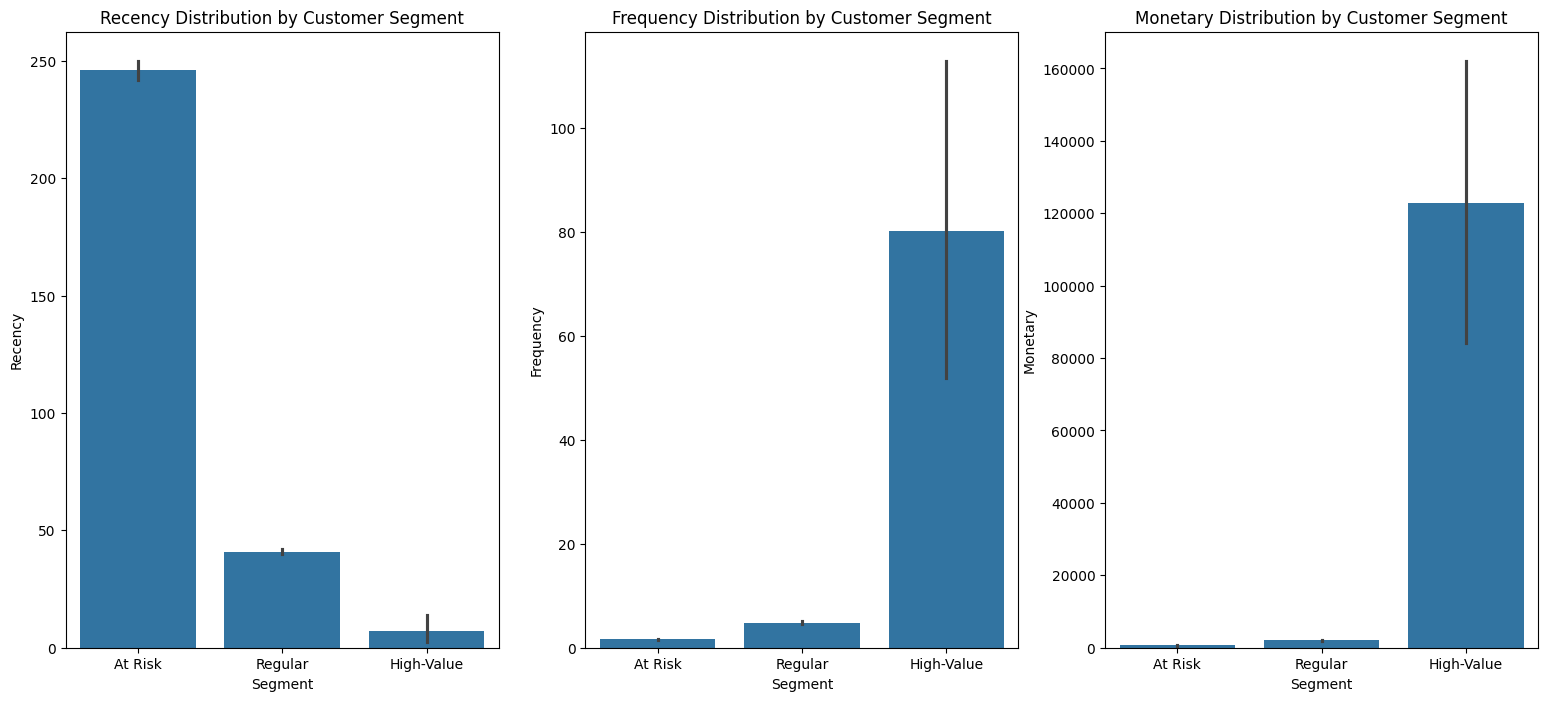

In [30]:
# Visualizing the profiles 

plt.figure(figsize=[19,8])
plt.subplot(1,3,1)
sns.barplot(x='Segment',y='Recency',data=rfm)
plt.title('Recency Distribution by Customer Segment')

plt.subplot(1,3,2)
sns.barplot(x='Segment',y='Frequency',data=rfm)
plt.title('Frequency Distribution by Customer Segment')

plt.subplot(1,3,3)
sns.barplot(x='Segment',y='Monetary',data=rfm)
plt.title('Monetary Distribution by Customer Segment')

plt.show()

In [31]:
cust_item = df.pivot_table(index='CustomerID',
                          columns='StockCode',
                          values='Quantity',
                          fill_value=0)

In [32]:
# Computing Cosine similarity between products
from sklearn.metrics.pairwise import cosine_similarity

product_similarity = cosine_similarity(cust_item.T)
product_similarity_df = pd.DataFrame(product_similarity,
                                    index=cust_item.columns,
                                    columns=cust_item.columns)

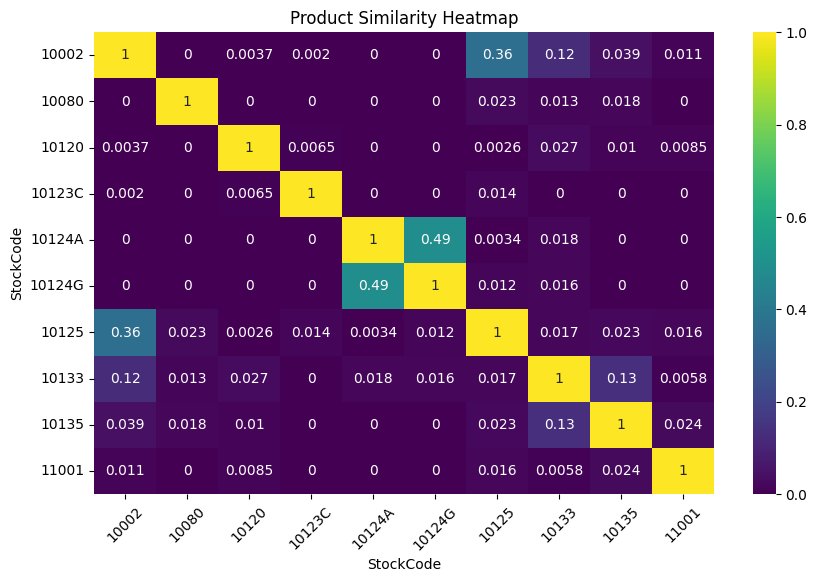

In [33]:
# visualizing 
plt.figure(figsize=[10,6])
sns.heatmap(product_similarity_df.iloc[:10,:10],cmap='viridis',annot=True)
plt.title('Product Similarity Heatmap')
plt.xticks(rotation=45)
plt.show()

In [34]:
# Lets check whether k=3 is optimal or not using Silhouette score 
from sklearn.metrics import silhouette_score
score = silhouette_score(X_scaled,rfm['Clusters'])
print(f"Silhouette Score for k=3: {score:.3f}")

Silhouette Score for k=3: 0.585


In [35]:
# this Silhouette score is pretty good to continue

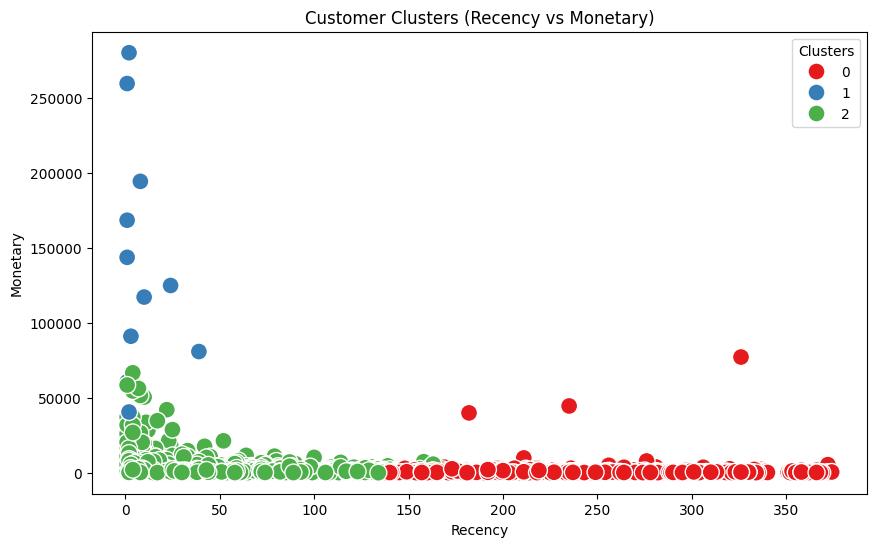

In [36]:
# Visualizing the Clusters 
# Recency vs Monetary 
plt.figure(figsize=[10,6])
sns.scatterplot(x='Recency',y='Monetary',data=rfm,hue='Clusters',palette='Set1',s=150)
plt.title('Customer Clusters (Recency vs Monetary)')
plt.xlabel('Recency')
plt.ylabel('Monetary')
plt.legend(title='Clusters')
plt.show()

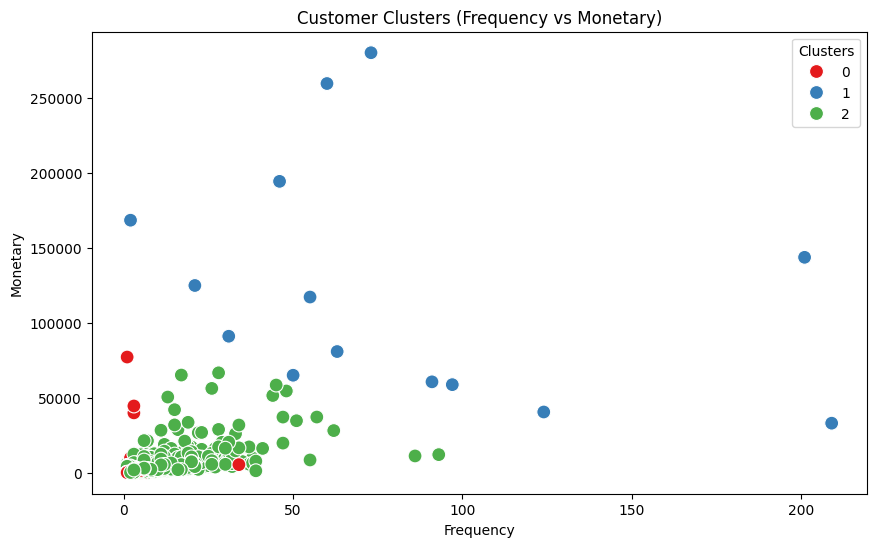

In [37]:
# Frequency vs Monetary
plt.figure(figsize=[10,6])
sns.scatterplot(data=rfm,x='Frequency',y='Monetary',hue='Clusters',palette='Set1',s=100)
plt.title('Customer Clusters (Frequency vs Monetary)')
plt.xlabel('Frequency')
plt.ylabel('Monetary')
plt.legend(title='Clusters')
plt.show()

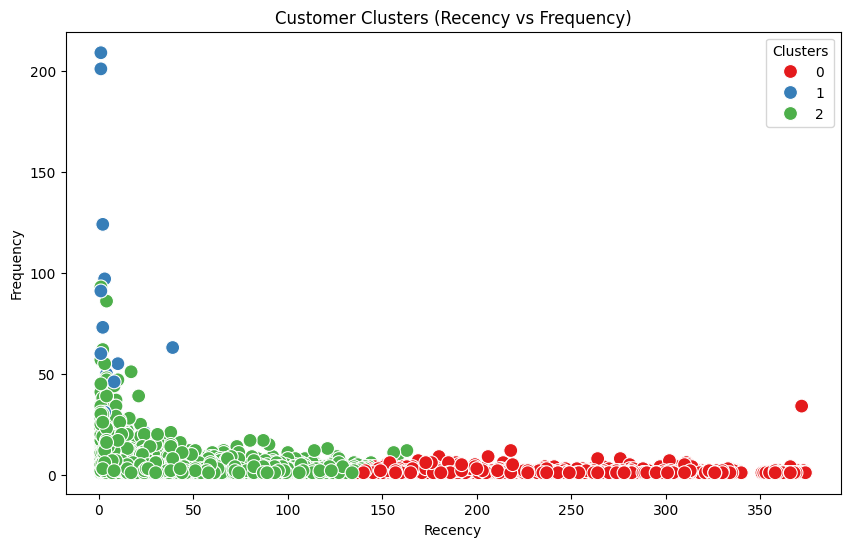

In [38]:
# Recency vs Frequency 
plt.figure(figsize=[10,6])
sns.scatterplot(data=rfm,x='Recency',y='Frequency',hue='Clusters',palette='Set1',s=100)
plt.title('Customer Clusters (Recency vs Frequency)')
plt.xlabel('Recency')
plt.ylabel('Frequency')
plt.legend(title='Clusters')
plt.show()

In [39]:
import pickle

# Save your RFM dataframe
with open('rfm.pkl', 'wb') as f:
    pickle.dump(rfm, f)

# Save the KMeans model
with open('kmeans_model.pkl', 'wb') as f:
    pickle.dump(kmeans, f)


In [40]:
# Saving the product similarity matrix
with open('product_similarity.pkl', 'wb') as f:
    pickle.dump(product_similarity_df, f)

In [41]:
import pickle

# Load RFM dataframe
with open('rfm.pkl', 'rb') as f:
    rfm = pickle.load(f)

# Load KMeans clustering model
with open('kmeans_model.pkl', 'rb') as f:
    kmeans = pickle.load(f)

# Load product similarity matrix
with open('product_similarity.pkl', 'rb') as f:
    product_similarity_df = pickle.load(f)


In [42]:
product_map = df[['StockCode', 'Description']].drop_duplicates()
product_map.to_csv('product_map.csv', index=False)